### Work and Health
1. Importing the data
* Functions to filter & clean the data
2. data exploration
    1. basic exploration
    2. statistical exploration
    3. visual exploration

In [114]:
#Import the basic libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
plt.style.use('ggplot')

### Import diseases data

In [2]:
df_diseases_1 = pd.read_csv('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-1/IHME-GBD_2019_DATA-16b07a3d-1.csv')
df_diseases_2 = pd.read_csv('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-2/IHME-GBD_2019_DATA-16b07a3d-2.csv')
df_diseases = df_diseases_1.append(df_diseases_2).reset_index()
df_diseases.drop(columns = 'index', inplace = True)

### Function to filter usefull disease data

In [3]:
#data cleaning - function that receives year of analysis, gender, metric and measure. Returns the "cleaned" df

def get_df_dis(df,year,gender,metric,measure):
    
    year = int(year)
    
    #drop redundant columns (code for each feature, mainly)
    df.copy().drop(columns=['measure_id','location_id','measure_name','sex_id','age_id','age_name','cause_id','metric_id'\
                         ,'upper','lower'], inplace=True)
    
    #filter by gender and year (Male or Female)
    df = df.loc[df_diseases['sex_name'].isin([gender])]\
.loc[df_diseases['year'] == year].drop(columns=['sex_name','year']).copy()
    
    #filter by metric (Number, Percent or Rate)
    df = df.loc[df.metric_name == metric].copy()
    df.drop(columns = ['metric_name'],inplace = True)
    
    #filter by measure (Incidence or Prevalence)
    df = df.loc[df.measure_name == measure].copy()
    df.drop(columns = ['measure_name'],inplace = True)
    
    #pivoting table with disease names = columns
    df = df.copy().pivot(index='location_name', columns = 'cause_name', values = 'val')
    
    df.drop(columns = ['Stroke','Headache disorders'],inplace = True)
    
    return df

### Import health cost data

In [4]:
df_health_cost = pd.read_excel('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/Health_expenditure_WB/Health_expenditure_WB.xls',na_values='..')

### Function to filter usefull HC data

In [5]:
def get_df_hc(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SH.XPD.GHED.PP.CD':'Public_cost','SH.XPD.PVTD.PP.CD':'Private_cost'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import GDP p/capita data

In [6]:
df_gdp = pd.read_excel('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/GPD_WB/GPD_CAPITA_WB.xlsx',na_values='..')

### Function to filter usefull GDP data

In [7]:
def get_gdp(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'NY.GDP.PCAP.CD':'GDP_per_cap'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import Employment data

In [8]:
df_employment = pd.read_excel('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/Employment_WB_2/Employment_WB_2.xlsx',na_values='..')

### Function to filter usefull employment data

In [9]:
def get_employment(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename columns for better readability
    df.rename(columns={'SL.AGR.EMPL.FE.ZS':'per_female_agriculture',\
                      'SL.AGR.EMPL.MA.ZS':'per_male_agriculture',\
                      'SL.AGR.EMPL.ZS':'per_total_agriculture',\
                      'SL.EMP.TOTL.SP.ZS':'per_total_employment',\
                      'SL.EMP.TOTL.SP.MA.ZS':'per_male_employment',\
                      'SL.EMP.TOTL.SP.FE.ZS':'per_female_employment',\
                      'SL.IND.EMPL.FE.ZS':'per_female_industry',\
                      'SL.IND.EMPL.MA.ZS':'per_male_industry',\
                      'SL.IND.EMPL.ZS':'per_total_industry',\
                      'SL.SRV.EMPL.FE.ZS':'per_female_services',\
                      'SL.SRV.EMPL.MA.ZS':'per_male_services',\
                      'SL.SRV.EMPL.ZS':'per_total_services'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Unemployment & Labor force data

In [10]:
df_unemp_lforce = pd.read_excel('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/UNEMP_LABORFORCE/unemp_lforce.xlsx',na_values='..')

In [11]:
def get_unemp_lforce(df,year):
        #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SL.TLF.CACT.ZS':'Total_Labor_Force', 'SL.UEM.TOTL.ZS':'Unemployment_rate'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Hours worked

In [12]:
df_hours_work = pd.read_excel('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/HOURS_ILO/HOURS_ILO.xlsx',na_values='..')

In [13]:
def get_hours_work(df,year):
    
    year = int(year)
        
    # remove unnecessary years
    df = df[['ref_area.label','obs_value']].loc[df.time == year].copy()
    
    df.set_index('ref_area.label', inplace = True)
    
    df = df.rename_axis('location_name')
        
    df.rename(columns={'obs_value':'Yearly_work_hours'}, inplace = True)
    
    return df

### SUMMARY OF ALL DATA GATHERED

### Merging all, considering all genders & yr = 2009

In [86]:
year = '2011'
df1 = get_df_dis(df_diseases,year,'Both','Rate','Incidence')
df2 = get_df_hc(df_health_cost,year)
df3 = get_gdp(df_gdp,year)
df4 = get_employment(df_employment,year)
df5 = get_unemp_lforce(df_unemp_lforce,year)
df6 = get_hours_work(df_hours_work,year)

#### merge ####

df7 = pd.merge(df1,df2, on='location_name', how='inner')
df8 = pd.merge(df7,df3, on='location_name', how='inner')
df9 = pd.merge(df8,df4, on='location_name', how='inner')
df10 = pd.merge(df9,df5, on='location_name', how='inner')
df11 = pd.merge(df10,df6, on='location_name', how='inner')

#remove gender related columns:
col_remove = ['per_female_agriculture','per_male_agriculture','per_male_employment','per_female_employment',\
             'per_female_industry','per_male_industry','per_female_services','per_male_services']
complete = df11.drop(columns = col_remove)

### Basic statistical analysis

In [77]:
complete

,Anxiety disorders,Bipolar disorder,Depressive disorders,Dermatitis,Musculoskeletal disorders,Public_cost,Private_cost,GDP_per_cap,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Yearly_work_hours
location_name,,,,,,,,,,,,,,,
Afghanistan,765.977631,68.635863,4518.788864,3871.050783,2553.754594,7.678760,100.336464,591.162759,53.560001,42.259998,14.750000,31.690001,47.759998,11.51,246178.863
Albania,575.274722,47.550216,2448.988941,5342.053593,5562.496536,239.541031,240.674606,4437.142885,45.389999,52.020000,18.870001,35.750000,60.130001,13.48,42626.014
Algeria,740.071998,66.022895,4615.672852,4658.153190,3818.968263,485.345856,201.786469,5462.260897,10.770000,38.250000,30.860001,58.369999,42.480000,9.96,429625.147
Angola,590.450485,48.790296,4988.035444,4353.703965,2231.893258,108.727570,54.369129,4615.468028,51.220001,71.709999,7.960000,40.820000,77.410004,7.36,359793.509
Argentina,729.760388,83.054055,2921.921599,3272.640898,3664.050241,1124.255737,728.710632,12848.864197,0.640000,56.279999,23.969999,75.389999,60.630001,7.18,661542.898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,708.411035,77.742966,3488.457939,3284.293357,4009.637019,955.447144,597.800415,14236.681188,9.790000,61.709999,20.780001,69.430000,65.860001,6.31,58225.867
Uzbekistan,353.587206,47.562917,2913.126995,4971.260100,3252.197225,123.909790,156.626328,1926.292997,27.090000,59.480000,22.740000,50.169998,62.610001,5.00,493142.227
Vanuatu,632.785429,25.494935,2312.541313,4681.507176,4114.927143,66.691795,11.804852,3264.537017,64.099998,68.419998,6.920000,28.980000,69.709999,1.85,2826.305


In [26]:
complete.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, Afghanistan to Zimbabwe
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Anxiety disorders          157 non-null    float64
 1   Bipolar disorder           157 non-null    float64
 2   Depressive disorders       157 non-null    float64
 3   Dermatitis                 157 non-null    float64
 4   Musculoskeletal disorders  157 non-null    float64
 5   Public_cost                152 non-null    float64
 6   Private_cost               152 non-null    float64
 7   GDP_per_cap                155 non-null    float64
 8   per_total_agriculture      157 non-null    float64
 9   per_total_employment       157 non-null    float64
 10  per_total_industry         157 non-null    float64
 11  per_total_services         157 non-null    float64
 12  Total_Labor_Force          157 non-null    float64
 13  Unemployment_rate          157 non-null 

In [16]:
complete.skew()

Anxiety disorders            0.550010
Bipolar disorder             0.251188
Depressive disorders         0.468465
Dermatitis                  -0.361964
Musculoskeletal disorders    0.307942
Public_cost                  1.839094
Private_cost                 4.235344
GDP_per_cap                  2.219867
per_total_agriculture        0.653955
per_total_employment         0.285899
per_total_industry           0.329752
per_total_services          -0.306074
Total_Labor_Force            0.260776
Unemployment_rate            1.412328
Yearly_work_hours            9.200545
dtype: float64

In [17]:
complete.kurt()

Anxiety disorders             0.608307
Bipolar disorder              0.371838
Depressive disorders          0.085916
Dermatitis                   -0.284530
Musculoskeletal disorders    -0.931164
Public_cost                   2.719467
Private_cost                 24.995237
GDP_per_cap                   5.422459
per_total_agriculture        -0.703915
per_total_employment         -0.274244
per_total_industry            0.970704
per_total_services           -0.893237
Total_Labor_Force            -0.239545
Unemployment_rate             1.929349
Yearly_work_hours            91.542004
dtype: float64

### Visual Exploration

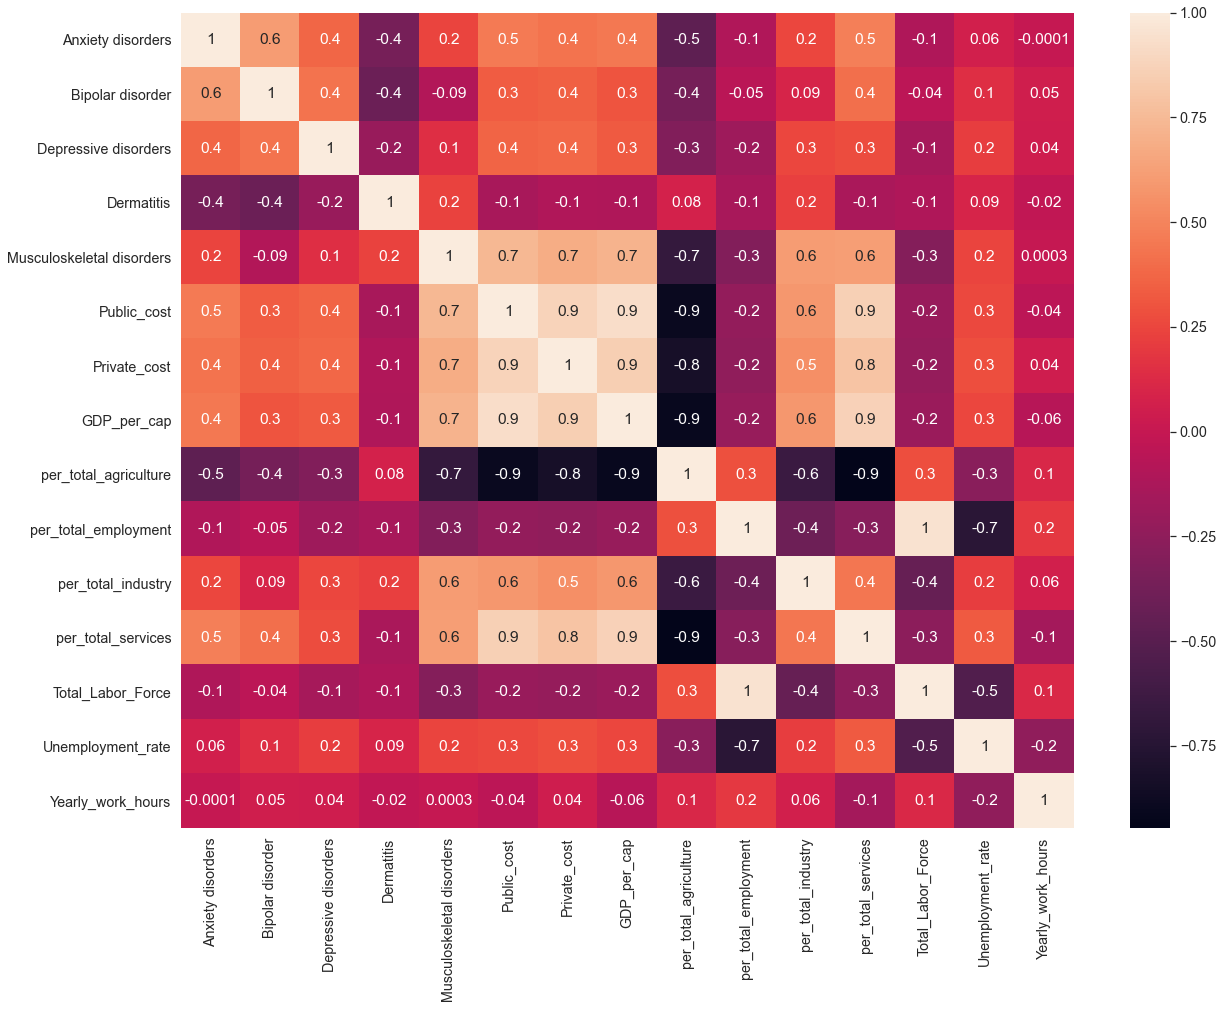

In [18]:
#correlation map
sns.set(font_scale=1.3)
df_corr = complete.corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g') 
plt.show()

* __per_total_agriculture__ (% of people out of the employed people that work in agriculture) seems to be negatively correlated with all the features. It is also strongly negatively (-0.9) correlated to __per_total_services, GDP_per_cap and Public Cost__ --> meaning that we probably should pick one pf them to include in a cluster analysis (check below subplots)<br><br>
* __Only three diseases__ seem to have relatively high |correlation| with other variables (0.7-0.8):
1. __Headache disorders__: >=0.7 (GDP_per_cap, Private_cost, Public_cost, __Musculoskeleton__)
2. __Musculoskeleton__: >=0.7 (per_total_agriculture, GDP_per_cap, Public_cost, __Stroke__)

--> retirar headache, stroke, somar mentais
--> dados que faltam:
1. consumo de alcool & tabaco (dados +)


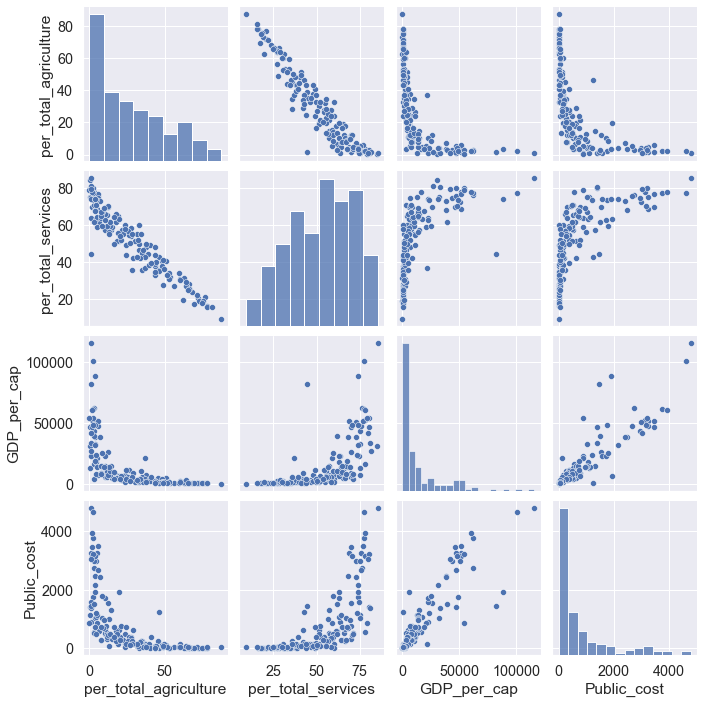

In [19]:
sns.pairplot(complete[['per_total_agriculture','per_total_services','GDP_per_cap','Public_cost']])
plt.show()

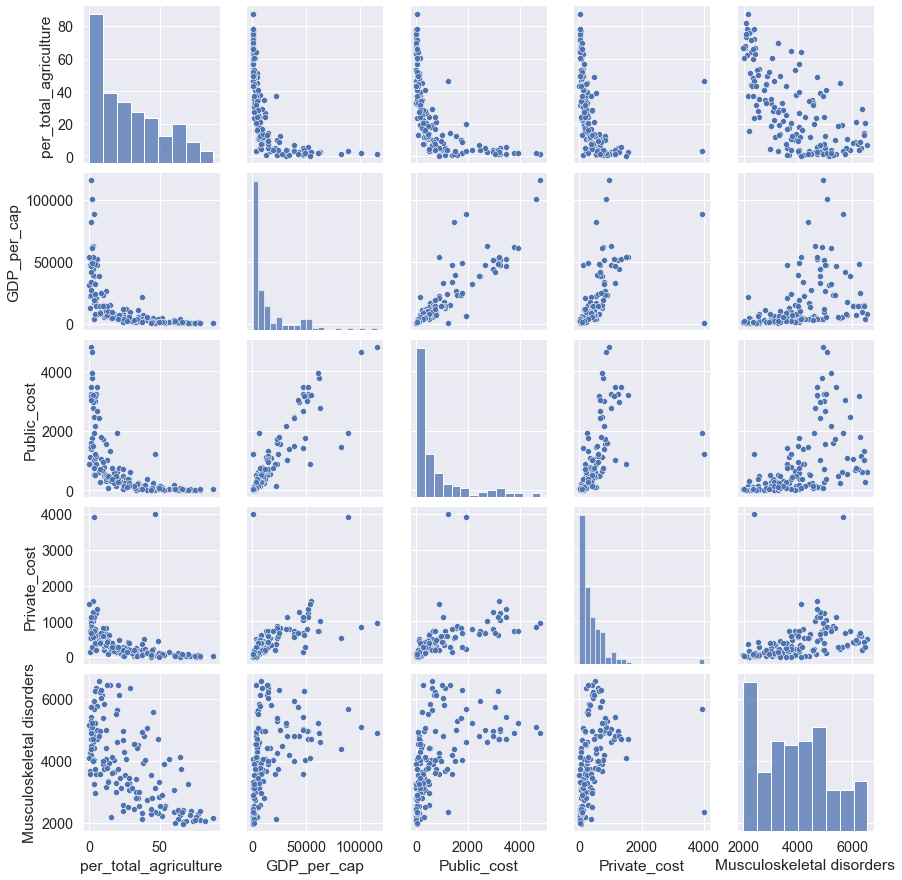

In [21]:
sns.pairplot(complete[['per_total_agriculture','GDP_per_cap','Public_cost','Private_cost','Musculoskeletal disorders']])
plt.show()

### Missing Values

In [23]:
#missing values (% of total):
complete.isna().sum()/1.57

Anxiety disorders            0.000000
Bipolar disorder             0.000000
Depressive disorders         0.000000
Dermatitis                   0.000000
Musculoskeletal disorders    0.000000
Public_cost                  3.184713
Private_cost                 3.184713
GDP_per_cap                  1.273885
per_total_agriculture        0.000000
per_total_employment         0.000000
per_total_industry           0.000000
per_total_services           0.000000
Total_Labor_Force            0.000000
Unemployment_rate            0.000000
Yearly_work_hours            0.000000
dtype: float64

In [39]:
#Our missing values
complete[complete.isna().any(axis=1)]

,Anxiety disorders,Bipolar disorder,Depressive disorders,Dermatitis,Musculoskeletal disorders,Public_cost,Private_cost,GDP_per_cap,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Yearly_work_hours
location_name,,,,,,,,,,,,,,,
Guam,628.860288,26.393240,2947.881845,5318.615132,5149.008697,NaN,NaN,30859.404353,0.310000,56.990002,14.920000,84.769997,65.739998,13.30,2861.313
Montenegro,555.870241,45.255394,3252.991054,5523.438917,5773.516912,NaN,NaN,7329.026063,5.470000,38.910000,19.549999,74.980003,48.439999,19.67,7973.046
Puerto Rico,657.284541,74.289970,3446.179524,5449.261183,4469.123640,NaN,NaN,27278.883050,1.320000,37.009998,17.200001,81.480003,43.910000,15.70,42660.824
Somalia,495.493143,53.780194,3473.922771,4316.467890,2070.611927,NaN,NaN,NaN,81.680000,41.160000,2.640000,15.680000,47.520000,13.38,95771.203
South Sudan,663.511410,53.260778,3464.444427,4389.049946,2119.947286,NaN,NaN,1516.403915,62.529999,63.990002,17.889999,19.580000,73.199997,12.57,128753.413
Syrian Arab Republic,854.723817,67.519896,4030.946695,4359.897297,3309.178846,82.711349,97.69017,NaN,13.230000,39.509998,31.430000,55.340000,43.230000,8.60,223872.008


In [40]:
complete_no_na = complete.dropna()

In [41]:
complete_no_na.info()
#data size is 96% the size of the original (4% data loss)

<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, Afghanistan to Zimbabwe
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Anxiety disorders          151 non-null    float64
 1   Bipolar disorder           151 non-null    float64
 2   Depressive disorders       151 non-null    float64
 3   Dermatitis                 151 non-null    float64
 4   Musculoskeletal disorders  151 non-null    float64
 5   Public_cost                151 non-null    float64
 6   Private_cost               151 non-null    float64
 7   GDP_per_cap                151 non-null    float64
 8   per_total_agriculture      151 non-null    float64
 9   per_total_employment       151 non-null    float64
 10  per_total_industry         151 non-null    float64
 11  per_total_services         151 non-null    float64
 12  Total_Labor_Force          151 non-null    float64
 13  Unemployment_rate          151 non-null 

### Using Gradient Boosting to fill in NA's

In [78]:
from sklearn.ensemble import GradientBoostingRegressor

In [87]:
def predict_missing(df, evaluated_column):
    """ Predicts and updates the missing values for the different features. """
    
    # defines the missing features
    cols = ['Public_cost','Private_cost', 'GDP_per_cap']
    
    # removes the evaluated feature
    cols.remove(evaluated_column)
    
    # defines the data to be used using the gradiant boosting method
    gb_data = df.select_dtypes(exclude=['object']).drop(columns = cols)
    
    # divides the data in missing and complete values
    feature_na = gb_data.loc[gb_data[evaluated_column].isna()]
    feature = gb_data.loc[~gb_data[evaluated_column].isna()]
    
    # defines the training data
    x_train = feature.drop(columns = evaluated_column)
    y_train = feature.copy().pop(evaluated_column)
    
    # fits the model
    gb = GradientBoostingRegressor(n_estimators=100)
    gb.fit(x_train, y_train)
    
    # predicts missing values
    x_predict = feature_na.drop(columns = evaluated_column)
    pred = pd.DataFrame(gb.predict(x_predict), index=x_predict.index, columns=[f'{evaluated_column}_na'])
    
    # fills the na values
    df = df.merge(pred, left_index=True, right_index=True, how='left')
    df.loc[df[evaluated_column].isna(), evaluated_column] = df[f'{evaluated_column}_na']
    df.drop(columns = [f'{evaluated_column}_na'], inplace=True)
    
    return df

In [88]:
complete_gb = (
    complete
    .pipe(predict_missing, 'Public_cost')
    .pipe(predict_missing, 'Private_cost')
    .pipe(predict_missing, 'GDP_per_cap')
)

In [47]:
complete_gb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, Afghanistan to Zimbabwe
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Anxiety disorders          157 non-null    float64
 1   Bipolar disorder           157 non-null    float64
 2   Depressive disorders       157 non-null    float64
 3   Dermatitis                 157 non-null    float64
 4   Musculoskeletal disorders  157 non-null    float64
 5   Public_cost                157 non-null    float64
 6   Private_cost               157 non-null    float64
 7   GDP_per_cap                157 non-null    float64
 8   per_total_agriculture      157 non-null    float64
 9   per_total_employment       157 non-null    float64
 10  per_total_industry         157 non-null    float64
 11  per_total_services         157 non-null    float64
 12  Total_Labor_Force          157 non-null    float64
 13  Unemployment_rate          157 non-null 

In [48]:
complete_gb.skew()

Anxiety disorders            0.550010
Bipolar disorder             0.251188
Depressive disorders         0.468465
Dermatitis                  -0.361964
Musculoskeletal disorders    0.307942
Public_cost                  1.806870
Private_cost                 4.180018
GDP_per_cap                  2.240309
per_total_agriculture        0.653955
per_total_employment         0.285899
per_total_industry           0.329752
per_total_services          -0.306074
Total_Labor_Force            0.260776
Unemployment_rate            1.412328
Yearly_work_hours            9.200545
dtype: float64

In [89]:
complete_gb.kurt()

Anxiety disorders             0.608307
Bipolar disorder              0.371838
Depressive disorders          0.085916
Dermatitis                   -0.284530
Musculoskeletal disorders    -0.931164
Public_cost                   2.590002
Private_cost                 24.806098
GDP_per_cap                   5.533725
per_total_agriculture        -0.703915
per_total_employment         -0.274244
per_total_industry            0.970704
per_total_services           -0.893237
Total_Labor_Force            -0.239545
Unemployment_rate             1.929349
Yearly_work_hours            91.542004
dtype: float64

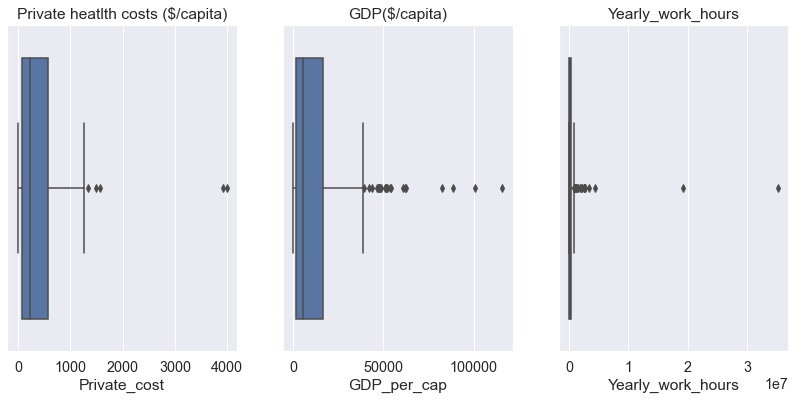

In [50]:
# check distribution of feature with highest kurtosis/skewness
fig, axes = plt.subplots(1,3, figsize = (14,6))
sns.boxplot(ax = axes[0], data = complete_gb, x = 'Private_cost').set(title='Private heatlth costs ($/capita)') 
sns.boxplot(ax = axes[1], data = complete_gb, x = 'GDP_per_cap').set(title='GDP($/capita)')
sns.boxplot(ax = axes[2], data = complete_gb, x = 'Yearly_work_hours').set(title='Yearly_work_hours')
plt.show()

In [53]:
complete.loc[complete.Private_cost > 3500]

,Anxiety disorders,Bipolar disorder,Depressive disorders,Dermatitis,Musculoskeletal disorders,Public_cost,Private_cost,GDP_per_cap,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Yearly_work_hours
location_name,,,,,,,,,,,,,,,
Liberia,546.592086,49.656894,4183.597501,4791.62441,2364.788293,1235.321289,3986.635742,596.897081,46.439999,73.839996,10.810000,42.750000,75.529999,2.24,74613.436
Switzerland,828.742223,62.869998,4806.902201,3253.03958,5676.299312,1924.072510,3916.969971,88415.628032,3.510000,64.489998,22.280001,74.209999,67.459999,4.40,161090.739


In [51]:
complete.loc[complete.Yearly_work_hours > 1e7]

,Anxiety disorders,Bipolar disorder,Depressive disorders,Dermatitis,Musculoskeletal disorders,Public_cost,Private_cost,GDP_per_cap,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Yearly_work_hours
location_name,,,,,,,,,,,,,,,
China,522.638450,17.262227,2619.750996,6474.560792,4514.072097,234.061859,201.299332,5618.132267,34.799999,67.860001,29.5,35.700001,71.059998,4.50,3.516678e+07
India,494.280831,35.015013,3663.200529,4942.084018,2844.336810,43.346920,105.476440,1458.103527,49.259998,50.279999,23.1,27.639999,53.290001,5.65,1.920959e+07


In [54]:
complete_gb.loc[complete_gb.GDP_per_cap > 100000]

,Anxiety disorders,Bipolar disorder,Depressive disorders,Dermatitis,Musculoskeletal disorders,Public_cost,Private_cost,GDP_per_cap,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Yearly_work_hours
location_name,,,,,,,,,,,,,,,
Luxembourg,735.714819,61.670868,3880.999183,3291.846818,4910.542012,4802.062988,944.476929,115761.507705,1.23,54.070000,13.36,85.410004,56.849998,4.90,8810.917
Norway,907.309019,59.554391,3526.220844,3604.407771,5091.140820,4636.580566,855.496582,100600.562408,2.37,63.110001,20.25,77.379997,65.199997,3.22,87927.758


In [90]:
#outliers removal
complete_no = complete_gb.drop(complete_gb[complete_gb['Private_cost'] > 3500].index)
complete_no.drop(complete_gb[complete_gb['GDP_per_cap'] > 100000].index,inplace = True)
complete_no.drop(complete_gb[complete_gb['Yearly_work_hours'] > 1e7].index,inplace = True)

### Re-evaluate statistics

In [56]:
# This is GB for missing values and Outliers according to previous cells
complete_no.skew()

Anxiety disorders            0.546154
Bipolar disorder             0.314130
Depressive disorders         0.461243
Dermatitis                  -0.434190
Musculoskeletal disorders    0.339328
Public_cost                  1.708922
Private_cost                 1.334971
GDP_per_cap                  1.722133
per_total_agriculture        0.665749
per_total_employment         0.317936
per_total_industry           0.338036
per_total_services          -0.341234
Total_Labor_Force            0.283247
Unemployment_rate            1.359769
Yearly_work_hours            3.285606
dtype: float64

In [57]:
complete_no.kurt()

Anxiety disorders             0.775560
Bipolar disorder              0.327039
Depressive disorders          0.023059
Dermatitis                   -0.212864
Musculoskeletal disorders    -0.887506
Public_cost                   1.986837
Private_cost                  1.462263
GDP_per_cap                   2.184339
per_total_agriculture        -0.698306
per_total_employment         -0.256519
per_total_industry            0.973387
per_total_services           -0.857130
Total_Labor_Force            -0.226792
Unemployment_rate             1.762795
Yearly_work_hours            12.169441
dtype: float64

[Text(0.5, 1.0, 'Yearly_work_hours')]

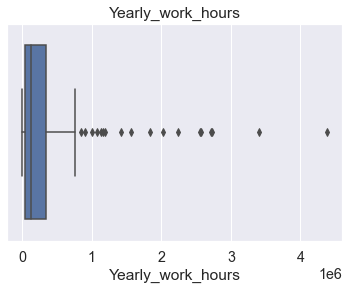

In [60]:
#Yearly_work_hours still has high skewness, let's see why
sns.boxplot(data = complete_no, x = 'Yearly_work_hours').set(title='Yearly_work_hours')

### Feature Engineering

In [52]:
# Add up all costs into Total health costs
# divide each sector (private and public) by total health costs to get percentage in each sector
# Add up all incidences to get a total incidence rate
# Divide all incidences by total incidence rate to get percentages
# multiply each sector's percentage by employment rate to get percentage "per capita"
# add up all mental hilness

In [82]:
def feature_df(df):
    
    #group all mental disordes in new variable
    df['mental_disorders'] = df['Anxiety disorders']+df['Bipolar disorder']+df['Depressive disorders']
    
    #group all costs in one single cost variable
    df['total_health_cost']=df['Private_cost']+df['Public_cost']
    
    #group all diseases in single total diseases var
    df['all_disorders'] = df['mental_disorders']+df['Musculoskeletal disorders']+df['Dermatitis']
    
    #normalize variables PER CAPITA
    #per_total_employment: Employment to population ratio, 15+, total (%)
    #per_total_sector: Employment in each sector (% of total employment)
    
    df['agriculture_percap'] = (df['per_total_employment']*df['per_total_agriculture'])/10000
    df['industry_percap'] = (df['per_total_employment']*df['per_total_industry'])/10000
    df['services_percap'] = (df['per_total_employment']*df['per_total_services'])/10000
    
    #unemployment is per total work force & labor force is per capita.
    df['Unemp_percapita'] = (df['Unemployment_rate']*df['Total_Labor_Force'])/10000
    
    df.drop(columns=['Anxiety disorders','Bipolar disorder','Depressive disorders',\
                     'Public_cost','Private_cost','per_total_agriculture',\
                    'per_total_industry','per_total_services',\
                    'Total_Labor_Force','Unemployment_rate'],inplace=True)
    return df

### Cluster Analysis:
1. Scneario 1: distribution of diseases over the world (3 variables) - which sectors have which diseases?
2. Scenario 2: Total work related diseases, Total health costs, employment rate......to be discussed

In [96]:
df_sc1 = feature_df(complete_no.copy())[['all_disorders','mental_disorders','Dermatitis','Musculoskeletal disorders','agriculture_percap','industry_percap','services_percap']]

In [97]:
df_sc1['mental_disorders_per'] = df_sc1['mental_disorders']/df_sc1['all_disorders']
df_sc1['Dermatitis_per'] = df_sc1['Dermatitis']/df_sc1['all_disorders']
df_sc1['Musc_per'] = df_sc1['Musculoskeletal disorders']/df_sc1['all_disorders']

In [100]:
df_sc1.drop(columns=['mental_disorders','Dermatitis','Musculoskeletal disorders','all_disorders'],inplace=True)

In [102]:
df_sc1

,agriculture_percap,industry_percap,services_percap,mental_disorders_per,Dermatitis_per,Musc_per
location_name,,,,,,
Afghanistan,0.226345,0.062333,0.133922,0.454518,0.328662,0.216820
Albania,0.236119,0.098162,0.185972,0.219786,0.382221,0.397993
Algeria,0.041195,0.118040,0.223265,0.390086,0.335146,0.274768
Angola,0.367299,0.057081,0.292720,0.460766,0.356485,0.182749
Argentina,0.003602,0.134903,0.424295,0.349975,0.306673,0.343351
...,...,...,...,...,...,...
Uruguay,0.060414,0.128233,0.428453,0.369503,0.283899,0.346598
Uzbekistan,0.161131,0.135258,0.298411,0.287255,0.430870,0.281875
Vanuatu,0.438572,0.047347,0.198281,0.252465,0.397842,0.349693


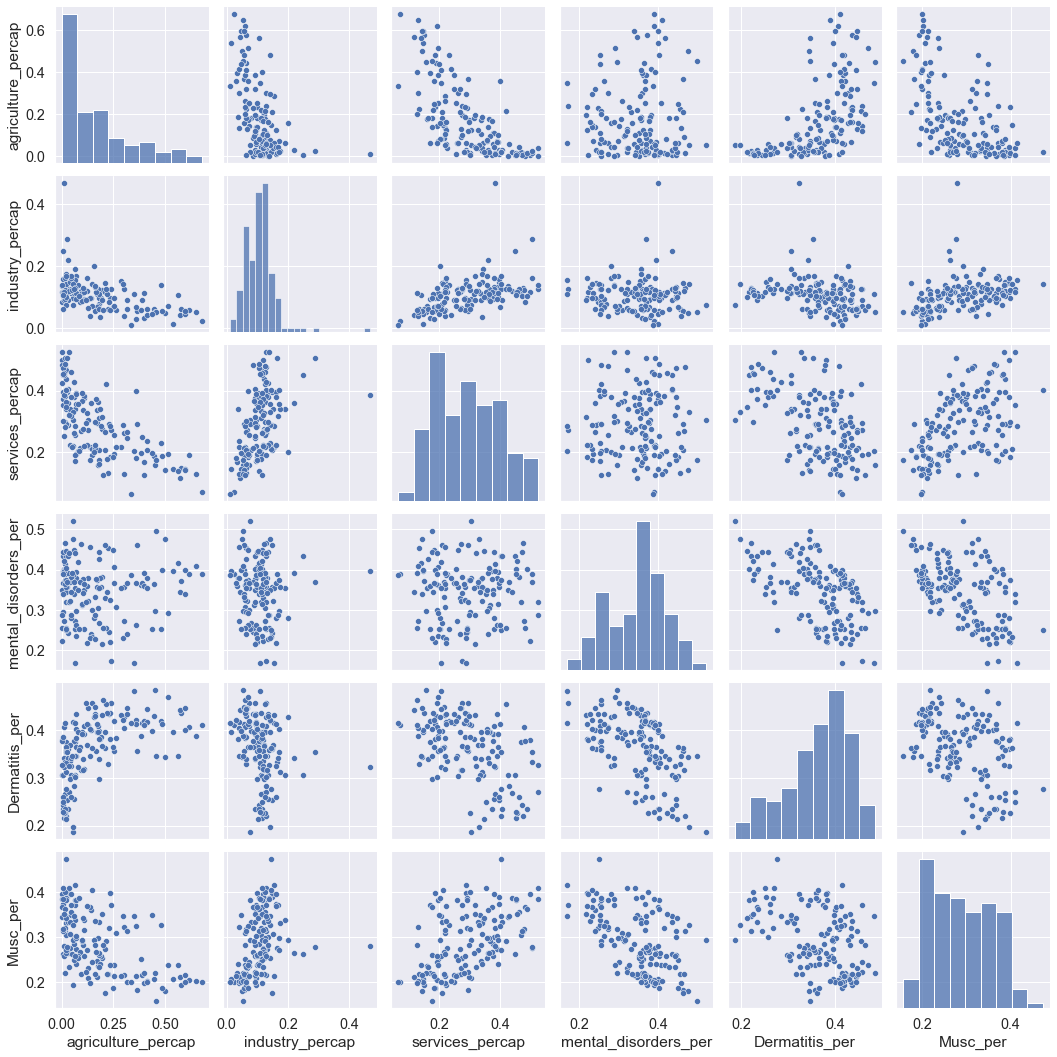

In [101]:
sns.pairplot(df_sc1)
plt.show()

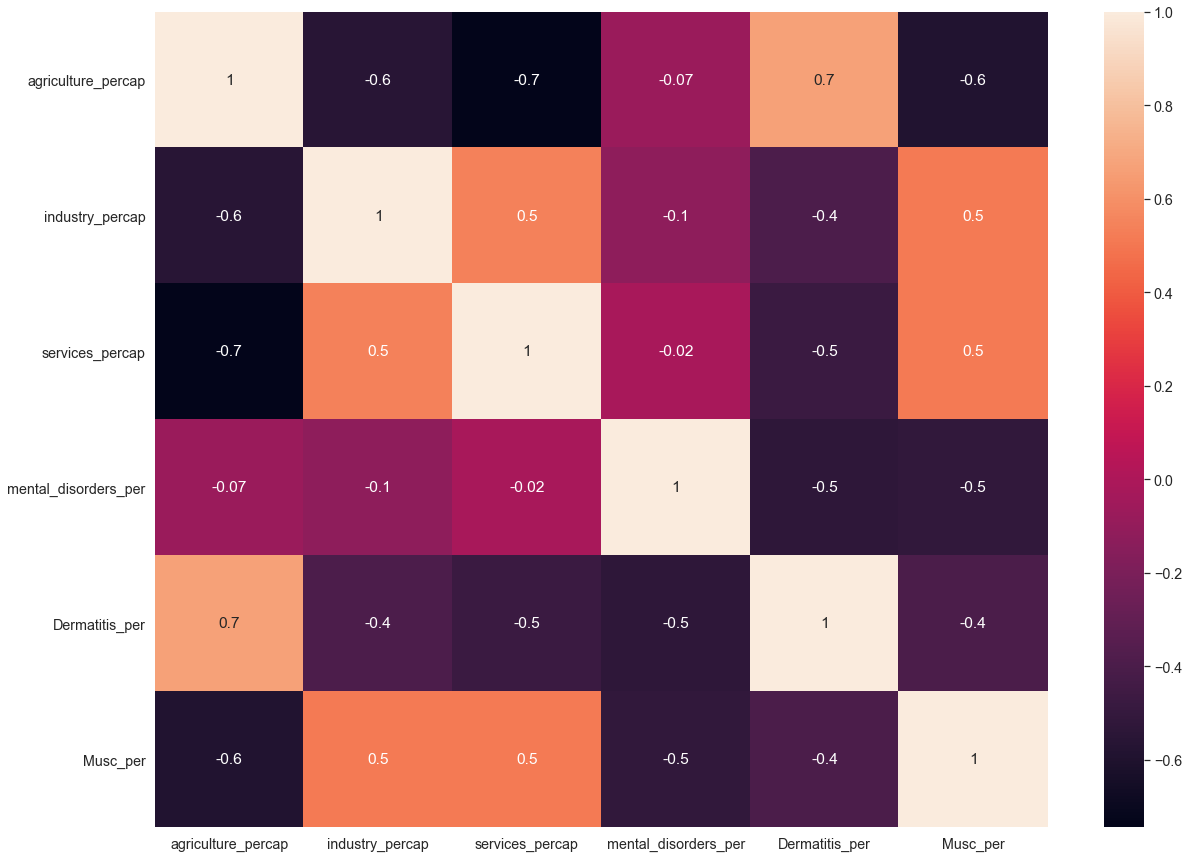

In [103]:
#correlation map:

sns.set(font_scale=1.3)
df_corr = df_sc1.corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g') 
plt.show()

### Normalize the data

In [106]:
minmax = MinMaxScaler()
minmax_sc1 = pd.DataFrame(minmax.fit_transform(df_sc1), columns=df_sc1.columns)

In [115]:
def evaluate_number_clusters(df, n):
    """ Evaluates the kmeans using different values of k. """
    
    # evalaution result list
    evaluation = []
    
    # evaluates different number of clusters
    for k in range(2, n):    

        # performs the kmeans cluster using the defined number of clusters
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        silhoutte_score = silhouette_score(df, kmeans.labels_)

        # appends the results to the 
        evaluation.append([k, kmeans.inertia_, silhoutte_score])

    # converts the evaluation do df
    evaluation = pd.DataFrame(evaluation, columns=['k', 'error', 'silhouette'])

    # plots the evaluation
    fig, axes = plt.subplots(2,1, figsize = (14,6))
    sns.lineplot(data=evaluation, x='k', y='error', ax=axes[0], markers=True, marker="o")
    sns.lineplot(data=evaluation, x='k', y='silhouette', ax=axes[1], markers=True, marker="o")
    
    # saves the evaluation
    #fig.savefig(f'{prefix}_number_of_clusters_evaluation.png')

In [118]:
def evaluate_cluster(df_cluster, df_evaluate, k):
    """ Evaluate a specific number of cluster. """ 
    
    # applies the kmeans with specific number of clusters
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster)
    labels = kmeans.labels_
    
    # updates the cluster data
    df_cluster = df_cluster.assign(cluster = labels)
    
    # defines the number of columns to be evaluated
    columns = df_cluster.columns[:-1]
    n_columns = len(columns)
    
    # defines the standard height and width of the graphs
    graph_height = 6
    praph_width = 6
    
    # defines the number of columns and rows to be ploted
    n_columns_subplot = n_columns if n_columns <= 3 else 3
    if n_columns // 3 == 0 and n_columns != 3:
         n_rows_subplot = 1
    elif n_columns // 3 != 0 and n_columns % 3 == 0:
        n_rows_subplot = n_columns // 3 
    else:
        n_rows_subplot = n_columns // 3 + 1

    # calculates the total heigh and width
    total_height = graph_height * n_rows_subplot
    total_width = praph_width * n_columns_subplot
    
    # creates the subplot structure
    fig, axes = plt.subplots(n_rows_subplot, n_columns_subplot, figsize=(total_width, total_height))
    
    # defines the initial axis location of the plots
    if n_rows_subplot == 1:
        p = 0
    else:
        r = 0
        c = 0
    
    # plots all the columns
    for column in columns:
        if n_rows_subplot == 1:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[p], fill=True)
            p += 1
        else:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[r, c], fill=True)
            if c == n_columns_subplot-1:
                r += 1
                c = 0
            else:
                c += 1
            
    # saves the plot
    
    # shows the plot
    plt.show()
    
    # updates the evalutiaon data
    df_evaluate = df_evaluate.assign(labels=kmeans.labels_)
    
    # defines the evalaution metrics for each cluster
    metrics = {'labels': 'count'}
    for column in df_evaluate.columns:
        if column != 'labels':
            metrics[column] = ['mean', 'median']
    results = df_evaluate.groupby('labels').agg(metrics).round(2)
    
    return results

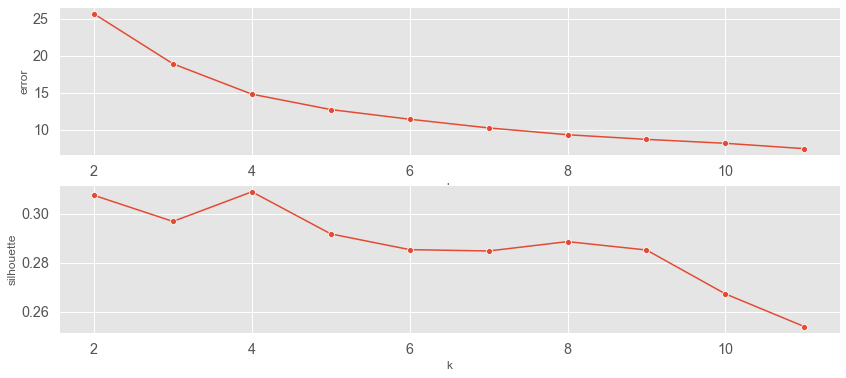

In [116]:
evaluate_number_clusters(minmax_sc1,12)

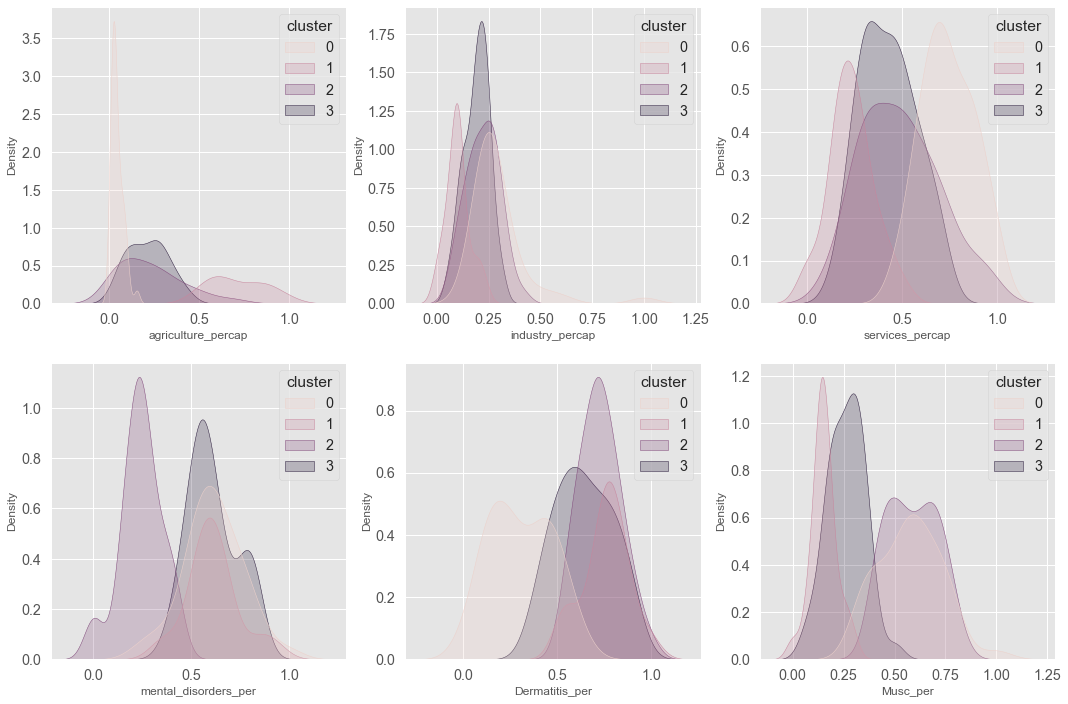

labels agriculture_percap        industry_percap         \
        count               mean median            mean median   
labels                                                           
0          40               0.03   0.02            0.15   0.13   
1          25               0.48   0.46            0.06   0.06   
2          42               0.16   0.14            0.11   0.11   
3          44               0.14   0.14            0.10   0.10   

       services_percap        mental_disorders_per        Dermatitis_per  \
                  mean median                 mean median           mean   
labels                                                                     
0                 0.40   0.40                 0.38   0.38           0.28   
1                 0.17   0.17                 0.38   0.38           0.41   
2                 0.29   0.29                 0.25   0.25           0.40   
3                 0.26   0.26                 0.38   0.38           0.38   

              Musc_per         
       median     mean median  
labels                         
0        0.27     0.34   0.34  
1        0.41     0.21   0.20  
2        0.40     0.34   0.34  
3        0.37     0.24   0.24

In [119]:
evaluate_cluster(minmax_sc1, df_sc1, 4)

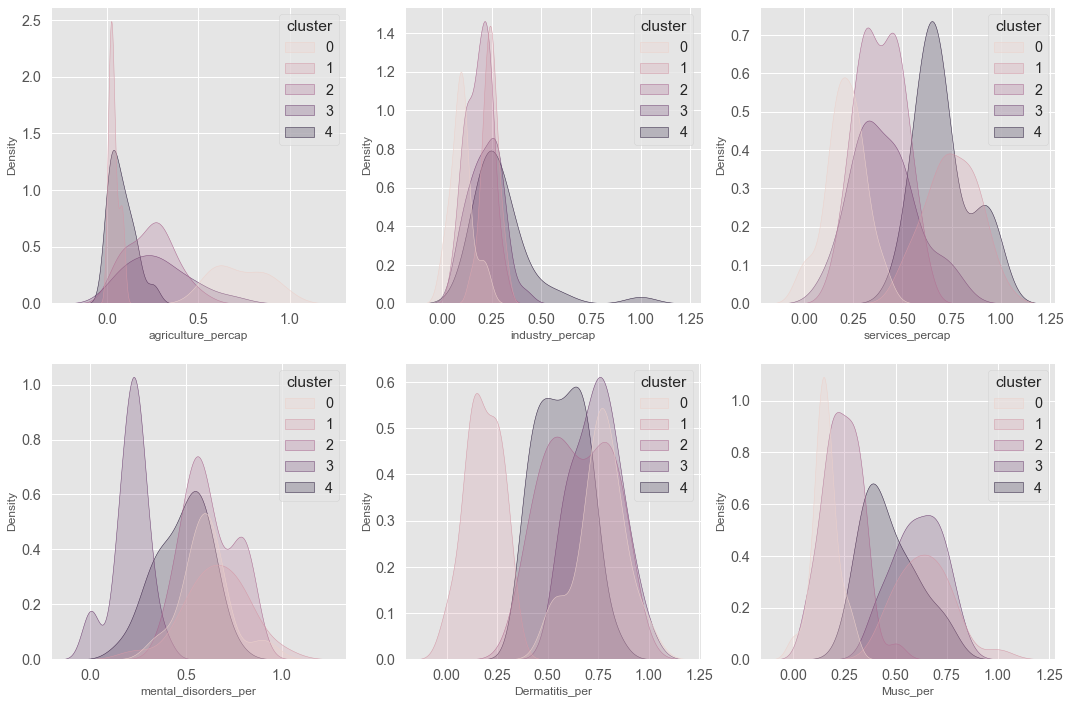

labels agriculture_percap        industry_percap         \
        count               mean median            mean median   
labels                                                           
0          23               0.49   0.48            0.05   0.05   
1          23               0.03   0.02            0.12   0.12   
2          39               0.16   0.17            0.09   0.10   
3          31               0.19   0.16            0.11   0.11   
4          35               0.05   0.04            0.15   0.13   

       services_percap        mental_disorders_per        Dermatitis_per  \
                  mean median                 mean median           mean   
labels                                                                     
0                 0.16   0.16                 0.38   0.38           0.41   
1                 0.41   0.40                 0.40   0.40           0.24   
2                 0.24   0.25                 0.39   0.38           0.38   
3                 0.25   0.23                 0.24   0.25           0.41   
4                 0.39   0.38                 0.34   0.35           0.36   

              Musc_per         
       median     mean median  
labels                         
0        0.41     0.21   0.20  
1        0.24     0.36   0.36  
2        0.38     0.23   0.23  
3        0.41     0.35   0.35  
4        0.36     0.31   0.30

In [120]:
evaluate_cluster(minmax_sc1, df_sc1, 5)